# Huffpost News Classification Using Natural Language Processing

Classifies news articles based on their short descriptions or summaries.

**By** - Shivani Elakurthy

---

## Table of Contents

1. Installing Required Packages
2. Reading the Dataset
3. Exploring the Dataset
4. Data Preprocessing
    1. Missing Data
    2. Grouping Categories
    2. NLP Preprocessing
5. NLP Feature Extraction
6. Encoding Labels
7. Training ML Models using **Bag of Words**
8. Training ML Models using **TF-IDF**
9. Training ML Models using **Text Vectorizer**

## Installing Required Packages

1. `spacy`
2. English model `en_core_web_sm`
3. `wordcloud`

In [1]:
import sys
!{sys.executable} -m pip install spacy
# python -m spacy download en_core_web_sm

In [2]:
!{sys.executable} -m pip install --user https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

In [86]:
!{sys.executable} -m pip install wordcloud

## Reading the Dataset

The dataset is downloaded from Kaggle [News Classification Dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset) as `huffpost_dataset.json`. I've uploaded a copy of this dataset to my [Github repository](https://github.com/elakurthyshivani/Huffpost-News-Classification.git).

The dataset `huffpost_dataset.json` is located at `Huffpost-News-Classification/data/`. The data is in the following format:
```json
{link:"...", headline:"...", ...}
{link:"...", headline:"...", ...}
...
{link:"...", headline:"...", ...}
```

Each line is a JSON for each news article. So, reading each line, converting it to a dictionary and adding it to a list `data_dict`.

### Clone Githib Repository

In [3]:
!git clone https://github.com/elakurthyshivani/Huffpost-News-Classification.git

fatal: destination path 'Huffpost-News-Classification' already exists and is not an empty directory.


In [4]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


### Reading the JSON file

In [5]:
import json

In [6]:
data_dict=[]

In [7]:
with open(r"Huffpost-News-Classification/data/huffpost_dataset.json", "r") as file:
    for line in file:
        data_dict.append(json.loads(line))

### Creating the Data Frame

In [8]:
import pandas as pd
import numpy as np

In [9]:
data=pd.DataFrame(data_dict)
data.shape

(209527, 6)

In [10]:
data.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


## Data Preprocessing

### Missing Data

#### Checking for null values

In [11]:
data.isnull().any()

link                 False
headline             False
category             False
short_description    False
authors              False
date                 False
dtype: bool

There are no null values in the dataset

#### Checking for empty strings

In [12]:
data[data.headline==""].shape

(6, 6)

In [13]:
data[data.short_description==""].shape

(19712, 6)

There are some rows with `""` empty strings for `headline` and `short_description`. These rows won't be helpful in classifying the news articles.

Dropping rows with empty strings for `headline` and `short_description`.

In [14]:
data.drop(data[data.headline==""].index, inplace=True)
data.drop(data[data.short_description==""].index, inplace=True)

In [15]:
data.shape

(189814, 6)

### Grouping Categories

There are 42 categories in this dataset.

In [16]:
data.category.unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

Grouping similar categories to reduce the count of unique categories to 10.

In [17]:
categories={"U.S. NEWS":"News & Politics",
            "WORLD NEWS":"News & Politics",
            "POLITICS":"News & Politics",
            "CRIME":"News & Politics",
            "MEDIA":"News & Politics",
            "THE WORLDPOST":"News & Politics",
            "WORLDPOST":"News & Politics",

            "MONEY":"Business & Finance",
            "BUSINESS":"Business & Finance",

            "COMEDY":"Entertainment & Arts",
            "CULTURE & ARTS":"Entertainment & Arts",
            "ENTERTAINMENT":"Entertainment & Arts",
            "ARTS & CULTURE":"Entertainment & Arts",
            "ARTS":"Entertainment & Arts",

            "TECH":"Education, Science, & Technology", 
            "SCIENCE":"Education, Science, & Technology",
            "EDUCATION":"Education, Science, & Technology", 
            "COLLEGE":"Education, Science, & Technology", 

            "WELLNESS":"Health & Wellness",
            "HEALTHY LIVING":"Health & Wellness",

            "PARENTING":"Family & Relationships",
            "PARENTS":"Family & Relationships",
            "WEDDINGS":"Family & Relationships",
            "DIVORCE":"Family & Relationships", 


            "STYLE":"Lifestyle & Living",
            "STYLE & BEAUTY":"Lifestyle & Living",
            "FOOD & DRINK":"Lifestyle & Living",
            "TASTE":"Lifestyle & Living",
            "HOME & LIVING":"Lifestyle & Living",
            "TRAVEL":"Lifestyle & Living",

            "SPORTS":"Sports",

            "WOMEN":"Demographics",
            "BLACK VOICES":"Demographics",
            "QUEER VOICES":"Demographics",
            "LATINO VOICES":"Demographics",
            
            "IMPACT":"Miscellaneous & Diverse Topics",
            "GREEN":"Miscellaneous & Diverse Topics",
            "RELIGION":"Miscellaneous & Diverse Topics",
            "GOOD NEWS":"Miscellaneous & Diverse Topics",
            "FIFTY":"Miscellaneous & Diverse Topics",
            "WEIRD NEWS":"Miscellaneous & Diverse Topics",
            "ENVIRONMENT":"Miscellaneous & Diverse Topics"
}

Updating the `category` feature to new values.

In [18]:
data["category"]=data.category.apply(lambda x: categories[x])

In [19]:
data.category.unique()

array(['News & Politics', 'Entertainment & Arts',
       'Family & Relationships', 'Education, Science, & Technology',
       'Sports', 'Miscellaneous & Diverse Topics', 'Health & Wellness',
       'Business & Finance', 'Lifestyle & Living', 'Demographics'],
      dtype=object)

### NLP Preprocessing

In [20]:
import spacy, nltk, re
from nltk.tag import pos_tag
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('universal_tagset')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dba5153\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dba5153\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\dba5153\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dba5153\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dba5153\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

#### List of Stopwords

Getting the list of stopwords in English.

In [21]:
from nltk.corpus import stopwords
stop_words_list=stopwords.words('english')

#### Lemmatizer

In [22]:
from nltk.stem import WordNetLemmatizer
wnl=WordNetLemmatizer()

### `lemmatize_token()` function

Lemmatizes the token according to its POS tag.

In [23]:
def lemmatize_token(token):
    token, tag=token
    if tag=="NOUN":
        return wnl.lemmatize(token, pos=nltk.corpus.wordnet.NOUN)
    elif tag=="VERB":
        return wnl.lemmatize(token, pos=nltk.corpus.wordnet.VERB)
    elif tag=="ADJ":
        return wnl.lemmatize(token, pos=nltk.corpus.wordnet.ADJ)
    if tag=="ADV":
        return wnl.lemmatize(token, pos=nltk.corpus.wordnet.ADJ)
    return wnl.lemmatize(token)

#### `clean_short_description()` function

Removes extra spaces, stopwords, and lemmatizes the words in `short_description` for each news article.

In [24]:
def clean_short_description(x):
    # Removing extra spaces anything other than alphabetic characters.
    x=re.sub("[\s0-9]+", " ", re.sub("[^\w ]", " ", x)).lower()
    # Removing stopwords
    x=[word for word in x.split() if not word in stop_words_list]
    # POS Tagging for proper lemmatization
    x=list(map(lemmatize_token, pos_tag(x, tagset='universal')))
    return ' '.join(x)

Applying the `clean_short_description` function to the `short_description` column and saving the results in a new `cleaned_short_description` column.

In [25]:
%%time
data["cleaned_short_description"]=data.short_description.apply(clean_short_description)
data.cleaned_short_description[:5]

Wall time: 2min 25s


0    health expert say early predict whether demand...
1    subdue passenger crew flee back aircraft confr...
2                             dog understand could eat
3    accidentally put grown toothpaste toddler toot...
4    amy cooper accuse investment firm franklin tem...
Name: cleaned_short_description, dtype: object

## Encoding Labels

### Label Encoder

Converting the categories to numeric values before passing them to machine learning models.

In [26]:
from sklearn.preprocessing import LabelEncoder

In [27]:
le=LabelEncoder()
y_le=le.fit_transform(np.array(data["category"]))
y_le

array([8, 8, 3, ..., 9, 9, 9])

### One Hot Encoder

Converting the categories to One Hot Encoding format. Labels should be in this format before passing them to neural network models.

In [28]:
from sklearn.preprocessing import OneHotEncoder

In [29]:
ohe=OneHotEncoder()
y_ohe=ohe.fit_transform(np.array(data["category"]).reshape(-1, 1))
y_ohe

<189814x10 sparse matrix of type '<class 'numpy.float64'>'
	with 189814 stored elements in Compressed Sparse Row format>

## Exploring the Dataset

In [30]:
import matplotlib.pyplot as plot
import seaborn as sb

### Count of each category present in the dataset

In [31]:
data.category.value_counts()

News & Politics                     47257
Lifestyle & Living                  33378
Health & Wellness                   23208
Entertainment & Arts                22681
Family & Relationships              19425
Demographics                        13986
Miscellaneous & Diverse Topics      12849
Business & Finance                   6887
Education, Science, & Technology     5729
Sports                               4414
Name: category, dtype: int64

### Ranked Bar Chart representing the count of each category

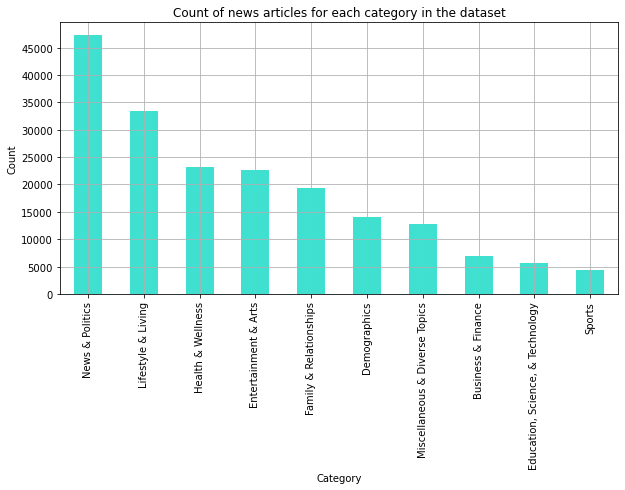

In [87]:
plot.figure(figsize=(10, 5))
data.category.value_counts().plot(kind="bar", color="turquoise")
plot.xlabel("Category")
plot.ylabel("Count")
plot.yticks(range(0, max(data.category.value_counts()), 5000))
plot.title("Count of news articles for each category in the dataset")
plot.grid()
plot.show()

### Word Cloud

In [88]:
from wordcloud import WordCloud

Wall time: 27.3 s


(-0.5, 2999.5, 1999.5, -0.5)

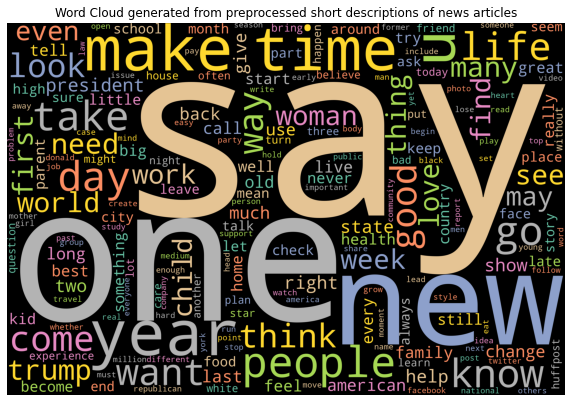

In [89]:
%%time
wordcloud=WordCloud(width=3000, height=2000, random_state=1, background_color='black', colormap='Set2', 
                     collocations=False).generate(' '.join(list(data.cleaned_short_description)))

plot.figure(figsize=(10, 8))
plot.title("Word Cloud generated from preprocessed short descriptions of news articles")
plot.imshow(wordcloud)
plot.axis("off");

### Word Cloud for `Education, Science, & Technology` Category

Wall time: 25 s


(-0.5, 2999.5, 1999.5, -0.5)

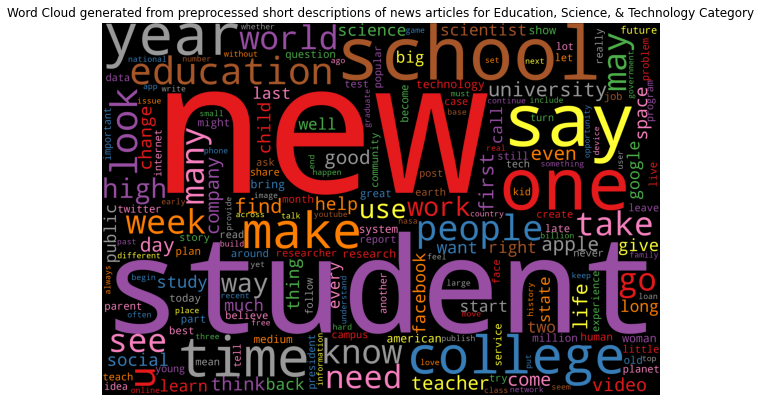

In [90]:
%%time
plot.figure(figsize=(10, 8))
plot.title("Word Cloud generated from preprocessed short descriptions of news articles for Education, Science, & Technology Category")
plot.imshow(WordCloud(width=3000, height=2000, random_state=1, background_color='black', colormap='Set1', 
                      collocations=False).generate(' '.join(list(data[data.category=="Education, Science, & Technology"].cleaned_short_description))))
plot.axis("off");

## NLP Feature Extraction

Choosing only `MAX_FEATURES` number of features before passing it to the ML models.

In [33]:
MAX_FEATURES=10000

### Count Vectorizer

`CountVectorier` returns a __Compressed Sparse Row (CSR)__ matrix. Converting it to a dense matrix will result in MemoryError. So, models that only accept CSR matrix as input will be used.

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
cv=CountVectorizer()
X_cv=cv.fit_transform(data.cleaned_short_description)
X_cv

<189814x64264 sparse matrix of type '<class 'numpy.int64'>'
	with 2148082 stored elements in Compressed Sparse Row format>

### TF-IDF

TF-IDF returns a __Compressed Sparse Row (CSR)__ matrix. Converting it to a dense matrix will result in MemoryError. So, models that only accept CSR matrix as input will be used.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
tfidf=TfidfVectorizer(norm="l2")
X_tfidf=tfidf.fit_transform(data.cleaned_short_description)
X_tfidf
# X.indices, X.data, X.shape

<189814x64264 sparse matrix of type '<class 'numpy.float64'>'
	with 2148082 stored elements in Compressed Sparse Row format>

### Text Vectorizer

Converts text short descriptions into numerical format. Features should be in this format before passing them to RNN models.

In [38]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [39]:
tv=TextVectorization(max_tokens=MAX_FEATURES)
tv.adapt(data.cleaned_short_description)
tv

In [40]:
#len(tv.get_vocabulary())

## Training ML Models using Features from `CountVectorizer`

### SelectKBest

Feature Selection using `SelectKBest`

In [45]:
from sklearn.feature_selection import SelectKBest, chi2

In [46]:
skb=SelectKBest(chi2, k=MAX_FEATURES)
X_cv=skb.fit_transform(X_cv, y_le)

### Train Test Split

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv=train_test_split(X_cv, y_le, test_size=0.15, 
                                                              random_state=29, stratify=y_le)
X_train_cv.shape, X_test_cv.shape

((161341, 10000), (28473, 10000))

### Building the ML Models

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [50]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score

#### Logistic Regression

In [51]:
%%time
lr_cv={"best_accuracy":0, "y_pred":None, "best_params":None}

for params in ParameterGrid({"solver":["liblinear", "saga"]}):
    # Fitting the training dataset and predicting the labels on the test dataset
    y_pred=LogisticRegression(verbose=2, random_state=29, max_iter=500, n_jobs=-1,
                              **params).fit(X_train_cv, y_train_cv).predict(X_test_cv)
    # Calculating the accuracy
    accuracy=accuracy_score(y_pred, y_test_cv)
    # Updating the best accuracy
    if accuracy>lr_cv["best_accuracy"]:
        lr_cv["best_accuracy"]=accuracy
        lr_cv["y_pred"]=y_pred
        lr_cv["best_params"]=params
        
for key, value in lr_cv.items():
    print(f"{key} : {value}")

C:\Users\dba5153\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 75 seconds
best_accuracy : 0.6064341657008394
y_pred : [8 3 3 ... 8 6 2]
best_params : {'solver': 'liblinear'}
Wall time: 1min 43s


C:\Users\dba5153\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.2min finished


#### SGD Classifier

In [52]:
%%time
sgd_cv={"best_accuracy":0, "y_pred":None, "best_params":None}

for params in ParameterGrid({"loss":["modified_huber", "squared_hinge"],
                             "learning_rate":["adaptive", "invscaling", "optimal"],
                             "eta0":[0.01, 0.1]}):
    # Fitting the training dataset and predicting the labels on the test dataset
    y_pred=SGDClassifier(random_state=29, n_jobs=-1,
                         max_iter=500, validation_fraction=0.15, 
                         **params).fit(X_train_cv, y_train_cv).predict(X_test_cv)
    # Calculating the accuracy
    accuracy=accuracy_score(y_pred, y_test_cv)
    # Updating the best accuracy
    if accuracy>sgd_cv["best_accuracy"]:
        sgd_cv["best_accuracy"]=accuracy
        sgd_cv["y_pred"]=y_pred
        sgd_cv["best_params"]=params
        
for key, value in sgd_cv.items():
    print(f"{key} : {value}")

C:\Users\dba5153\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


best_accuracy : 0.6101569908334211
y_pred : [8 5 3 ... 8 6 4]
best_params : {'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'modified_huber'}
Wall time: 1min 28s


C:\Users\dba5153\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


#### Linear SVM

In [53]:
%%time
svc_cv={"best_accuracy":0, "y_pred":None, "best_params":None}

for params in ParameterGrid({"loss":["hinge", "squared_hinge"],
                             "C":[1, 0.1, 0.05]}):
    # Fitting the training dataset and predicting the labels on the test dataset
    y_pred=LinearSVC(random_state=29, max_iter=1000, verbose=1,
                     **params).fit(X_train_cv, y_train_cv).predict(X_test_cv)
    # Calculating the accuracy
    accuracy=accuracy_score(y_pred, y_test_cv)
    # Updating the best accuracy
    if accuracy>svc_cv["best_accuracy"]:
        svc_cv["best_accuracy"]=accuracy
        svc_cv["y_pred"]=y_pred
        svc_cv["best_params"]=params
        
for key, value in svc_cv.items():
    print(f"{key} : {value}")

[LibLinear]

C:\Users\dba5153\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]

C:\Users\dba5153\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]

C:\Users\dba5153\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear][LibLinear]

C:\Users\dba5153\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]best_accuracy : 0.609630175956169
y_pred : [8 5 3 ... 8 6 4]
best_params : {'C': 0.1, 'loss': 'squared_hinge'}
Wall time: 5min 6s


#### K Neighbors Classifier

In [54]:
%%time
knc_cv={"best_accuracy":0, "y_pred":None, "best_params":None}

for params in ParameterGrid({"n_neighbors":[3, 4]}):
    # Fitting the training dataset and predicting the labels on the test dataset
    y_pred=KNeighborsClassifier(**params).fit(X_train_cv, y_train_cv).predict(X_test_cv)
    # Calculating the accuracy
    accuracy=accuracy_score(y_pred, y_test_cv)
    # Updating the best accuracy
    if accuracy>knc_cv["best_accuracy"]:
        knc_cv["best_accuracy"]=accuracy
        knc_cv["y_pred"]=y_pred
        knc_cv["best_params"]=params
        
for key, value in knc_cv.items():
    print(f"{key} : {value}")

best_accuracy : 0.23963052716608718
y_pred : [0 6 7 ... 3 6 1]
best_params : {'n_neighbors': 4}
Wall time: 2min 25s


#### Random Forest Classifier

In [55]:
%%time
rfc_cv={"best_accuracy":0, "y_pred":None, "best_params":None}

for params in ParameterGrid({"criterion":["gini", "entropy"]}):
    # Fitting the training dataset and predicting the labels on the test dataset
    y_pred=RandomForestClassifier(n_estimators=10, random_state=29, 
                                  n_jobs=-1, verbose=True,
                                  **params).fit(X_train_cv, y_train_cv).predict(X_test_cv)
    # Calculating the accuracy
    accuracy=accuracy_score(y_pred, y_test_cv)
    # Updating the best accuracy
    if accuracy>rfc_cv["best_accuracy"]:
        rfc_cv["best_accuracy"]=accuracy
        rfc_cv["y_pred"]=y_pred
        rfc_cv["best_params"]=params
        
for key, value in rfc_cv.items():
    print(f"{key} : {value}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   13.6s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   15.5s remaining:   10.3s


best_accuracy : 0.4866364626137042
y_pred : [8 8 3 ... 3 6 4]
best_params : {'criterion': 'gini'}
Wall time: 44.5 s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


#### Decision Tree Classifier

In [56]:
%%time
dtc_cv={"best_accuracy":0, "y_pred":None, "best_params":None}

for params in ParameterGrid({"criterion":["gini", "entropy"]}):
    # Fitting the training dataset and predicting the labels on the test dataset
    y_pred=DecisionTreeClassifier(random_state=29, 
                                  **params).fit(X_train_cv, y_train_cv).predict(X_test_cv)
    # Calculating the accuracy
    accuracy=accuracy_score(y_pred, y_test_cv)
    # Updating the best accuracy
    if accuracy>dtc_cv["best_accuracy"]:
        dtc_cv["best_accuracy"]=accuracy
        dtc_cv["y_pred"]=y_pred
        dtc_cv["best_params"]=params
        
for key, value in dtc_cv.items():
    print(f"{key} : {value}")

best_accuracy : 0.42334843535981453
y_pred : [0 8 3 ... 3 6 2]
best_params : {'criterion': 'gini'}
Wall time: 3min 7s


The highest accuracy is achieved by **`SGDClassifier`**

## Training ML Models using Features from `TfidfVectorizer`

### SelectKBest

Feature Selection using `SelectKBest`

In [57]:
from sklearn.feature_selection import SelectKBest, chi2

In [58]:
skb=SelectKBest(chi2, k=MAX_FEATURES)
X_tfidf=skb.fit_transform(X_tfidf, y_le)

### Train Test Split

In [59]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf=train_test_split(X_tfidf, y_le, test_size=0.15, 
                                                              random_state=29, stratify=y_le)
X_train_tf.shape, X_test_tf.shape

((161341, 10000), (28473, 10000))

### Building the ML Models

Packages are imported in the above section

#### Logistic Regression

In [60]:
%%time
lr_tf={"best_accuracy":0, "y_pred":None, "best_params":None}

for params in ParameterGrid({"solver":["liblinear", "saga"]}):
    # Fitting the training dataset and predicting the labels on the test dataset
    y_pred=LogisticRegression(verbose=2, random_state=29, max_iter=500, n_jobs=-1,
                              **params).fit(X_train_tf, y_train_tf).predict(X_test_tf)
    # Calculating the accuracy
    accuracy=accuracy_score(y_pred, y_test_tf)
    # Updating the best accuracy
    if accuracy>lr_tf["best_accuracy"]:
        lr_tf["best_accuracy"]=accuracy
        lr_tf["y_pred"]=y_pred
        lr_tf["best_params"]=params
        
for key, value in lr_tf.items():
    print(f"{key} : {value}")

C:\Users\dba5153\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


[LibLinear]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 23 epochs took 3 seconds
best_accuracy : 0.6022898886664559
y_pred : [8 3 3 ... 3 6 2]
best_params : {'solver': 'saga'}
Wall time: 13.5 s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished


#### SGD Classifier

In [61]:
%%time
sgd_tf={"best_accuracy":0, "y_pred":None, "best_params":None}

for params in ParameterGrid({"loss":["modified_huber", "squared_hinge"],
                             "learning_rate":["adaptive", "invscaling", "optimal"],
                             "eta0":[0.01, 0.1]}):
    # Fitting the training dataset and predicting the labels on the test dataset
    y_pred=SGDClassifier(random_state=29, n_jobs=-1,
                         max_iter=500, validation_fraction=0.15, 
                         **params).fit(X_train_tf, y_train_tf).predict(X_test_tf)
    # Calculating the accuracy
    accuracy=accuracy_score(y_pred, y_test_tf)
    # Updating the best accuracy
    if accuracy>sgd_tf["best_accuracy"]:
        sgd_tf["best_accuracy"]=accuracy
        sgd_tf["y_pred"]=y_pred
        sgd_tf["best_params"]=params
        
for key, value in sgd_tf.items():
    print(f"{key} : {value}")

best_accuracy : 0.6010957749446845
y_pred : [8 6 3 ... 4 6 4]
best_params : {'eta0': 0.1, 'learning_rate': 'adaptive', 'loss': 'squared_hinge'}
Wall time: 29.3 s


#### Linear SVM

In [62]:
%%time
svc_tf={"best_accuracy":0, "y_pred":None, "best_params":None}

for params in ParameterGrid({"loss":["hinge", "squared_hinge"],
                             "C":[1, 0.1, 0.05]}):
    # Fitting the training dataset and predicting the labels on the test dataset
    y_pred=LinearSVC(random_state=29, max_iter=1000, verbose=1,
                     **params).fit(X_train_tf, y_train_tf).predict(X_test_tf)
    # Calculating the accuracy
    accuracy=accuracy_score(y_pred, y_test_tf)
    # Updating the best accuracy
    if accuracy>svc_tf["best_accuracy"]:
        svc_tf["best_accuracy"]=accuracy
        svc_tf["y_pred"]=y_pred
        svc_tf["best_params"]=params
        
for key, value in svc_tf.items():
    print(f"{key} : {value}")

[LibLinear]

C:\Users\dba5153\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear][LibLinear]

C:\Users\dba5153\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear][LibLinear]

C:\Users\dba5153\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]best_accuracy : 0.6146524777859727
y_pred : [8 3 3 ... 8 6 4]
best_params : {'C': 1, 'loss': 'squared_hinge'}
Wall time: 2min 23s


#### K Neighbors Classifier

In [63]:
%%time
knc_tf={"best_accuracy":0, "y_pred":None, "best_params":None}

for params in ParameterGrid({"n_neighbors":[3, 4]}):
    # Fitting the training dataset and predicting the labels on the test dataset
    y_pred=KNeighborsClassifier(**params).fit(X_train_tf, y_train_tf).predict(X_test_tf)
    # Calculating the accuracy
    accuracy=accuracy_score(y_pred, y_test_tf)
    # Updating the best accuracy
    if accuracy>knc_tf["best_accuracy"]:
        knc_tf["best_accuracy"]=accuracy
        knc_tf["y_pred"]=y_pred
        knc_tf["best_params"]=params
        
for key, value in knc_tf.items():
    print(f"{key} : {value}")

best_accuracy : 0.27900115899273
y_pred : [8 1 3 ... 1 6 3]
best_params : {'n_neighbors': 4}
Wall time: 2min 23s


#### Random Forest Classifier

In [64]:
%%time
rfc_tf={"best_accuracy":0, "y_pred":None, "best_params":None}

for params in ParameterGrid({"criterion":["gini", "entropy"]}):
    # Fitting the training dataset and predicting the labels on the test dataset
    y_pred=RandomForestClassifier(n_estimators=10, random_state=29, 
                                  n_jobs=-1, verbose=True,
                                  **params).fit(X_train_tf, y_train_tf).predict(X_test_tf)
    # Calculating the accuracy
    accuracy=accuracy_score(y_pred, y_test_tf)
    # Updating the best accuracy
    if accuracy>rfc_tf["best_accuracy"]:
        rfc_tf["best_accuracy"]=accuracy
        rfc_tf["y_pred"]=y_pred
        rfc_tf["best_params"]=params
        
for key, value in rfc_tf.items():
    print(f"{key} : {value}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   13.3s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   15.2s remaining:   10.1s


best_accuracy : 0.4997717135531907
y_pred : [8 6 3 ... 3 6 4]
best_params : {'criterion': 'gini'}
Wall time: 44.9 s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


#### Decision Tree Classifier

In [65]:
%%time
dtc_tf={"best_accuracy":0, "y_pred":None, "best_params":None}

for params in ParameterGrid({"criterion":["gini", "entropy"]}):
    # Fitting the training dataset and predicting the labels on the test dataset
    y_pred=DecisionTreeClassifier(random_state=29, 
                                  **params).fit(X_train_tf, y_train_tf).predict(X_test_tf)
    # Calculating the accuracy
    accuracy=accuracy_score(y_pred, y_test_tf)
    # Updating the best accuracy
    if accuracy>dtc_tf["best_accuracy"]:
        dtc_tf["best_accuracy"]=accuracy
        dtc_tf["y_pred"]=y_pred
        dtc_tf["best_params"]=params
        
for key, value in dtc_tf.items():
    print(f"{key} : {value}")

best_accuracy : 0.43321743406033786
y_pred : [8 6 3 ... 3 6 4]
best_params : {'criterion': 'gini'}
Wall time: 3min 14s


The highest accuracy is achieved by **`LinearSVC`**

## Training ML Models using Features from `TextVectorization`

### Train Test Split

Output from One Hot Encoder will be used as labels. `y_train_tv` and `y_test_tv` will be passed to RNN models.

In [66]:
X_train_tv, X_test_tv, y_train_tv, y_test_tv=train_test_split(data.cleaned_short_description, y_ohe, 
                                                              test_size=0.15, 
                                                              random_state=29, stratify=y_le)
X_train_tv.shape, X_test_tv.shape

((161341,), (28473,))

### Building the ML Models

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

#### LSTM

In [80]:
%%time
model_srnn=Sequential()
model_srnn.add(Input(shape=(1, ), dtype="string"))
model_srnn.add(tv)
model_srnn.add(Embedding(MAX_FEATURES+1, 256)) # 512
#model_srnn.add(SimpleRNN(128, return_sequences=True, dropout=0.25, recurrent_dropout=0.25))
model_srnn.add(Bidirectional(LSTM(128, dropout=0.25)))
model_srnn.add(Dense(128, activation="relu"))
model_srnn.add(Dropout(0.5))
model_srnn.add(Dense(10, activation="softmax"))

model_srnn.compile(optimizer=Adam(0.005), loss='categorical_crossentropy', 
                   metrics=['accuracy'])
model_srnn.fit(X_train_tv, y_train_tv.todense(), epochs=3, validation_split=0.15, 
               batch_size=256)

_, accuracy_srnn=model_srnn.evaluate(X_test_tv, y_test_tv.todense())
accuracy_srnn

Epoch 1/3
536/536 [==============================] - 373s 692ms/step - loss: 1.4410 - accuracy: 0.5423 - val_loss: 1.2648 - val_accuracy: 0.5948
Epoch 2/3
536/536 [==============================] - 388s 724ms/step - loss: 1.1942 - accuracy: 0.6217 - val_loss: 1.2429 - val_accuracy: 0.6024
Epoch 3/3
890/890 [==============================] - 21s 24ms/step - loss: 1.2625 - accuracy: 0.6004
Wall time: 19min 9s


0.600358247756958

#### GRU

In [82]:
model_gru=Sequential()
model_gru.add(Input(shape=(1, ), dtype="string"))
model_gru.add(tv)
model_gru.add(Embedding(MAX_FEATURES+1, 512))
# model.add(Bidirectional(GRU(128, return_sequences=True, dropout=0.25, recurrent_dropout=0.25)))
model_gru.add(Bidirectional(GRU(128, dropout=0.25)))
model_gru.add(Dense(128, activation="relu"))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(10, activation="softmax"))

model_gru.compile(optimizer=Adam(0.005), loss='categorical_crossentropy', 
                   metrics=['accuracy'])
model_gru.fit(X_train_tv, y_train_tv.todense(), epochs=3, validation_split=0.15, 
               batch_size=256)

_, accuracy_gru=model_gru.evaluate(X_test_tv, y_test_tv.todense())
accuracy_gru

Epoch 1/3
536/536 [==============================] - 427s 793ms/step - loss: 1.4458 - accuracy: 0.5431 - val_loss: 1.2617 - val_accuracy: 0.5976
Epoch 2/3
536/536 [==============================] - 493s 921ms/step - loss: 1.2115 - accuracy: 0.6140 - val_loss: 1.2428 - val_accuracy: 0.6029
Epoch 3/3
890/890 [==============================] - 27s 30ms/step - loss: 1.3299 - accuracy: 0.5911


0.5910511612892151

The highest accuracy is achieved by **Bidirectional `LSTM`**

## Final Verdict

The highest accuracy is achieved by `LinearSVC` model trained using `TfidfVectorizer`.